# LIBRARIES AND CONSTANTS

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
tqdm.pandas()
%matplotlib inline

/home/michal/anaconda3/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/michal/anaconda3/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/michal/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next v

In [2]:
TRAIN_AUDIO_PATH = './train/audio'
TEST_AUDIO_PATH = './test/audio'
LABEL_FOR_BACKGROUND_NOISE = "silence"
LABEL_FOR_UNKNOWN = "unknown"
LABELS_TO_PREDICT = ['yes', 'no', 'up', 'down', 'left',
                  'right', 'on', 'off', 'stop', 'go', LABEL_FOR_BACKGROUND_NOISE, LABEL_FOR_UNKNOWN]
SPECSAMPLES = 126

# DEFINITIONS

In [3]:
def load_train_set(train_audio_path):
    train_labels = os.listdir(train_audio_path)
    print(f'Number of labels: {len(train_labels)}')

    train_file_labels = dict()
    for label in train_labels:
        files = os.listdir(train_audio_path + '/' + label)
        for f in files:
            if ".wav" not in f:
                continue
            train_file_labels[label + '/' + f] = label

    train = pd.DataFrame.from_dict(train_file_labels, orient='index')
    train = train.reset_index(drop=False)
    train = train.rename(columns={'index': 'file', 0: 'folder'})
    train = train[['folder', 'file']]
    train = train.sort_values('file')
    train = train.reset_index(drop=True)
    print(train.shape)
    
    return train

In [4]:
def set_label(df):
    df['label'] = df.folder.apply(lambda x: x if x in LABELS_TO_PREDICT else (LABEL_FOR_BACKGROUND_NOISE if x in ("_background_noise_", "generated_silence") else LABEL_FOR_UNKNOWN) )

In [5]:
def get_spectogram(file, workdir=".", nsamples=SPECSAMPLES):
    path = f"{workdir}/{file}"
    y, sr = librosa.load(path, sr=16000)
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128)
    spect = librosa.power_to_db(spect, ref=np.max)
    # Pad or truncate
    if spect.shape[1] < nsamples:
        spect = np.pad(spect, [(0, 0), (nsamples - spect.shape[1], 0)], mode='constant')
    else:
        spect = spect[:, :nsamples]
#     print(spect)
    return spect

In [6]:
def generate_silence(silences, how_many, workdir=".", nsamples=SPECSAMPLES):
    long_silence = []
    durations = []
    for file in silences:
        path = f"{workdir}/{file}"
        y, sr = librosa.load(path, sr=16000)
        long_silence.append(y)
        durations.append(len(y))
    long_silence = np.concatenate(long_silence, axis=None)
    mean_duration = int(np.mean(durations))
    spectograms = []
    for i in tqdm(range(how_many)):
        y = np.random.choice(long_silence, mean_duration)
        librosa.output.write_wav(f"{workdir}/generated_silence/silence_{i}.wav", y, 16000)

In [7]:
def plot_spect(spect):
    print(spect.shape)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spect.T, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

In [8]:
def load_X_sub(test_audio_path):
    
    clips = []
    files = os.listdir(test_audio_path)
    for f in files:
        if ".wav" not in f:
            continue
        clips.append(f)

    clips = list(set(clips))
    
    return pd.DataFrame.from_dict({'file': clips})

In [9]:
def in_subset(file, valid, test, subset):
    user_id = file[-21:-13]
    random.seed(user_id)
    v = random.random()
    if subset == "valid":
        return v < valid
    if subset == "test":
        return valid <= v < valid + test
    else:
        return valid + test <= v
    
def split_set(X, y, file, valid=0.2, test=0.2):
    X_train = X[file.progress_apply(in_subset, args=(valid, test, "train"))]
    X_valid = X[file.progress_apply(in_subset, args=(valid, test, "valid"))]
    X_test = X[file.progress_apply(in_subset, args=(valid, test, "test"))]
    y_train = y[file.progress_apply(in_subset, args=(valid, test, "train"))]
    y_valid = y[file.progress_apply(in_subset, args=(valid, test, "valid"))]
    y_test = y[file.progress_apply(in_subset, args=(valid, test, "test"))]
    return X_train, X_valid, X_test, y_train, y_valid, y_test


## TRAIN LOAD

In [12]:
train = load_train_set(TRAIN_AUDIO_PATH)

Number of labels: 33
(67027, 2)


In [13]:
train.head(100)

folder                                     file
0   _background_noise_  _background_noise_/doing_the_dishes.wav
1   _background_noise_     _background_noise_/dude_miaowing.wav
2   _background_noise_     _background_noise_/exercise_bike.wav
3   _background_noise_        _background_noise_/pink_noise.wav
4   _background_noise_       _background_noise_/running_tap.wav
..                 ...                                      ...
95                 bed                bed/122c5aa7_nohash_0.wav
96                 bed                bed/12529547_nohash_0.wav
97                 bed                bed/126a31d2_nohash_0.wav
98                 bed                bed/129c7d8d_nohash_0.wav
99                 bed                bed/13199b79_nohash_0.wav

[100 rows x 2 columns]

## TRAIN DATA EXTRACTION

In [14]:
set_label(train)

In [15]:
train.sample(5)

folder                        file label
51117   stop  stop/c68cf200_nohash_0.wav  stop
19722     go    go/742d6431_nohash_1.wav    go
62628    yes   yes/28460a60_nohash_1.wav   yes
35034    off   off/b83c1acf_nohash_2.wav   off
33798    off   off/3367cff6_nohash_1.wav   off

In [16]:
train.label.value_counts()

unknown    41039
stop        2380
yes         2377
up          2375
no          2375
go          2372
right       2367
on          2367
down        2359
off         2357
left        2353
silence     2306
Name: label, dtype: int64

In [15]:
train_spectograms = train.file.progress_apply(get_spectogram, args=(TRAIN_AUDIO_PATH,))

100%|██████████| 67027/67027 [10:48<00:00, 103.31it/s] 


In [16]:
train_spectograms

0        [[-80.0, -80.0, -80.0, -80.0, -73.62739, -59.2...
1        [[-80.0, -80.0, -80.0, -80.0, -73.65136, -52.9...
2        [[-80.0, -80.0, -80.0, -80.0, -66.43666, -53.1...
3        [[-6.6396313, -5.137903, -4.8761406, -8.778662...
4        [[-80.0, -80.0, -80.0, -80.0, -46.653328, -39....
                               ...                        
67022    [[-80.0, -73.18053, -54.438164, -48.617176, -4...
67023    [[-67.6582, -73.13919, -65.97224, -75.35868, -...
67024    [[-72.57779, -67.06022, -67.73896, -71.551254,...
67025    [[-46.025948, -46.858215, -48.12985, -48.20847...
67026    [[-69.7767, -66.79169, -57.27336, -54.674583, ...
Name: file, Length: 67027, dtype: object

(128, 126)


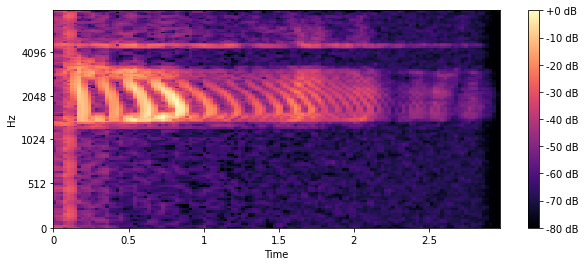

In [18]:
plot_spect(train_spectograms.iloc[10])

In [17]:
X = np.rollaxis(np.dstack(train_spectograms), -1)
y = pd.get_dummies(train.label)

NameError: name 'train_spectograms' is not defined

In [18]:
X_train, X_valid, X_test, y_train, y_valid, y_test = split_set(X, y, train.file)

NameError: name 'X' is not defined

In [21]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(41604, 128, 126)
(12583, 128, 126)
(12840, 128, 126)
(41604, 12)
(12583, 12)
(12840, 12)


In [22]:
np.save("X_train", X_train)
np.save("X_valid", X_valid)
np.save("X_test", X_test)

In [23]:
y_train.to_csv("./y_train.csv", header=True, index=False)
y_valid.to_csv("./y_valid.csv", header=True, index=False)
y_test.to_csv("./y_test.csv", header=True, index=False)

## SUBMISSION DATA EXTRACTION

In [10]:
X_sub = load_X_sub('./test/audio')

In [11]:
X_sub

file
0       clip_49d1062d9.wav
1       clip_394eca28c.wav
2       clip_cdce8b1b1.wav
3       clip_3424e5ff7.wav
4       clip_9d36282ef.wav
...                    ...
158533  clip_68fed96c2.wav
158534  clip_e430338bc.wav
158535  clip_6eaa57be8.wav
158536  clip_7fac9f99e.wav
158537  clip_02039a17c.wav

[158538 rows x 1 columns]

In [12]:
X_sub.to_csv('./file_sub.csv', index=False, header=True)

In [13]:
from tqdm import tqdm
tqdm.pandas()
sub_spectograms = X_sub.file.progress_apply(get_spectogram, args=(TEST_AUDIO_PATH,))

/home/michal/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 158538/158538 [21:56<00:00, 120.43it/s] 


(128, 126)


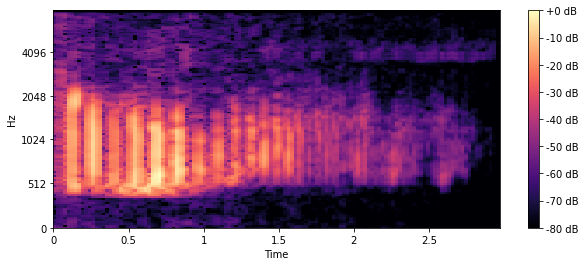

In [14]:
plot_spect(sub_spectograms.iloc[4])

In [15]:
X_sub = np.rollaxis(np.dstack(sub_spectograms), -1)

In [16]:
X_sub.shape

(158538, 128, 126)

In [17]:
np.save("X_sub", X_sub)